In [1]:
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.3f' % x)
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import os
from itertools import combinations

import numpy as np
import pickle
import data

import importlib
importlib.reload(data)

from data import update_expl_data, update_target_data, food_categories, preprocess_expl
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import json

In [2]:
"""
Set sample rate. In this notebook, all data will be resampled at the chosen frequency.
'MS' : Monthly (Month Start)
'W' : Weekly
'D' : Daily
"""

year_period = {'MS': 12, 'W': 52, 'D': 365}
frequency = 'MS'
one_year = year_period[frequency]
output_path = "./output/ensemble_TEST"
if not os.path.exists(output_path):
    if not os.path.exists("./output"):
        os.mkdir("./output")
    os.mkdir(output_path)

## Load Data From File

In [3]:
foodprice_categories = pd.read_csv("./foodprice_categories.txt", sep='\n', header=None)[0].to_list()
foodprice_df = pd.read_csv("./all_data.csv", index_col=0)
foodprice_df = foodprice_df.set_index(pd.DatetimeIndex(foodprice_df.index))
foodprice_df = foodprice_df[foodprice_categories]
foodprice_df

,Bakery and cereal products (excluding baby food),Dairy products and eggs,"Fish, seafood and other marine products",Food purchased from restaurants,Food,"Fruit, fruit preparations and nuts",Meat,Other food products and non-alcoholic beverages,Vegetables and vegetable preparations
1986-01-01,69.300,70.900,60.600,59.100,67.300,76.000,65.100,77.500,76.000
1986-02-01,70.300,70.800,61.300,59.100,66.900,77.600,64.200,78.100,68.400
1986-03-01,70.600,71.100,61.300,59.300,67.000,79.200,64.200,78.600,66.200
1986-04-01,71.300,71.000,61.400,59.700,67.700,82.200,63.600,79.500,71.100
1986-05-01,71.200,71.400,61.900,59.900,68.200,83.500,64.000,79.800,75.300
...,...,...,...,...,...,...,...,...,...
2021-06-01,157.700,145.300,146.200,163.900,156.800,144.500,176.700,142.200,153.400
2021-07-01,157.900,146.400,146.600,165.200,157.600,141.700,180.900,141.900,154.800
2021-08-01,158.500,148.300,146.800,165.900,158.000,142.500,182.100,141.700,152.200
2021-09-01,158.100,148.000,147.100,165.900,158.500,141.500,184.800,144.300,150.000


In [4]:
"""
Load ensemble configurations and scores. 
"""

results_df = pd.read_pickle(f"{output_path}/ensemble_results.pkl")
results_df

,mape,stddev,best_config
Bakery and cereal products (excluding baby food),0.022,0.010,[nbeatsfredvars_TEST]
Dairy products and eggs,0.022,0.008,[nbeatsfredvars_TEST]
"Fish, seafood and other marine products",0.016,0.004,"[nbeats_TEST, nbeatsfredvars_TEST, prophet_TEST]"
Food purchased from restaurants,0.008,0.007,[nbeatsfredvars_TEST]
Food,0.013,0.006,"[nbeatsfredvars_TEST, prophet_TEST]"
"Fruit, fruit preparations and nuts",0.030,0.017,"[nbeatsfredvars_TEST, prophet_TEST]"
Meat,0.026,0.010,[nbeatsfredvars_TEST]
Other food products and non-alcoholic beverages,0.014,0.005,"[nbeatsfredvars_TEST, prophet_TEST]"
Vegetables and vegetable preparations,0.041,0.024,"[nbeatsfredvars_TEST, prophet_TEST]"


## Final forecast

In [5]:
def get_final_forecast_ensemble(food_category, results_dict):

    forecasts = []
    exp_results = results_dict[food_category]
    for exp_name in exp_results:
        if exp_name.startswith('neuralprophet'):
            full_exp_name = f"{food_category}_{exp_name}".replace("_neuralprophet_202110_", '_')
            fc_df = pd.read_csv(f"./output/final_forecasts/{full_exp_name}/fc_final.csv")
        else:
            full_exp_name = exp_name
            fc_df = pd.read_csv(f"./output/{full_exp_name}/fc_final.csv")
        full_exp_name = full_exp_name.replace(f"{food_category}_", '')
        if "REF_DATE" in fc_df.columns:
            fc_df = fc_df.set_index("REF_DATE")
        elif "Unnamed: 0" in fc_df.columns:
            fc_df = fc_df.set_index("Unnamed: 0")
        elif "ds" in fc_df.columns:
            fc_df = fc_df.set_index("ds")
        fc_df.index = pd.DatetimeIndex(fc_df.index)
        fc_series = fc_df[food_category]
        fc_series = fc_series.rename(full_exp_name)
        print(full_exp_name)
        forecasts.append(fc_series)
    
    return pd.concat(forecasts, axis=1)


In [6]:
results = results_df["best_config"].to_dict()
results

{'Bakery and cereal products (excluding baby food)': ['nbeatsfredvars_TEST'],
 'Dairy products and eggs': ['nbeatsfredvars_TEST'],
 'Fish, seafood and other marine products': ['nbeats_TEST',
  'nbeatsfredvars_TEST',
  'prophet_TEST'],
 'Food purchased from restaurants': ['nbeatsfredvars_TEST'],
 'Food': ['nbeatsfredvars_TEST', 'prophet_TEST'],
 'Fruit, fruit preparations and nuts': ['nbeatsfredvars_TEST', 'prophet_TEST'],
 'Meat': ['nbeatsfredvars_TEST'],
 'Other food products and non-alcoholic beverages': ['nbeatsfredvars_TEST',
  'prophet_TEST'],
 'Vegetables and vegetable preparations': ['nbeatsfredvars_TEST',
  'prophet_TEST']}

In [7]:
final_forecasts_df = get_final_forecast_ensemble("Meat", results)
final_forecasts_df

FileNotFoundError: [Errno 2] No such file or directory: './output/nbeatsfredvars_TEST/fc_final.csv'

In [32]:
experiment_names = final_forecasts_df.columns

In [33]:
def get_final_forecast_df(food_category, experiment_names):

    forecasts = []

    for ex_name in experiment_names:
        fc_df = pd.read_csv(f"./output/{ex_name}/fc_final.csv")
        if "REF_DATE" in fc_df.columns:
            fc_df = fc_df.set_index("REF_DATE")
        elif "Unnamed: 0" in fc_df.columns:
            fc_df = fc_df.set_index("Unnamed: 0")
        elif "ds" in fc_df.columns:
            fc_df = fc_df.set_index("ds")
        fc_df.index = pd.DatetimeIndex(fc_df.index)
        fc_series = fc_df[food_category]
        fc_series = fc_series.rename(ex_name)
        forecasts.append(fc_series)

    return pd.concat(forecasts, axis=1)

In [34]:
final_forecasts_df = get_final_forecast_df("Meat", experiment_names)
final_forecasts_df

,nbeats_TEST,prophet_TEST
2021-11-01,176.602,175.822
2021-12-01,175.315,175.725
2022-01-01,172.130,176.180
2022-02-01,178.999,176.430
2022-03-01,172.354,176.825
2022-04-01,174.375,177.214
2022-05-01,174.862,177.883
2022-06-01,183.885,178.858
2022-07-01,191.337,179.484
2022-08-01,169.359,179.695


prophet_TEST


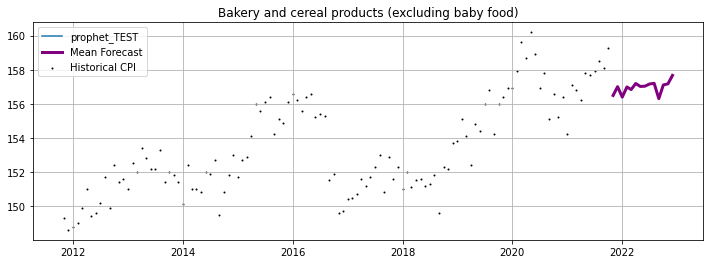

prophet_TEST


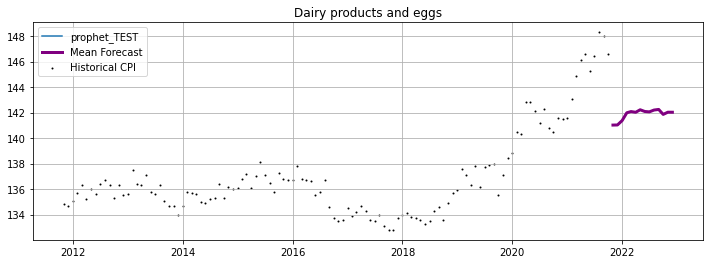

nbeats_TEST
prophet_TEST


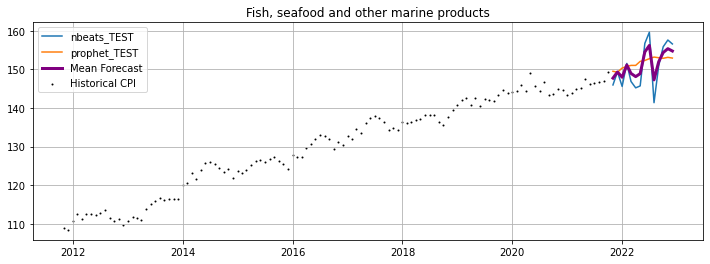

prophet_TEST


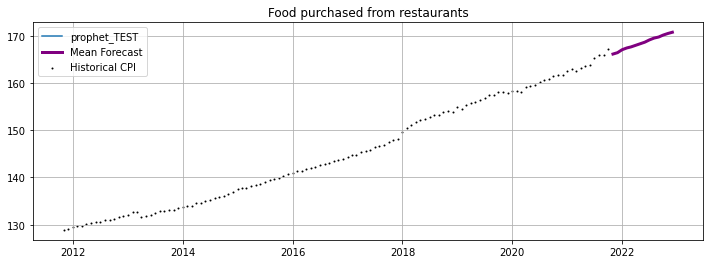

prophet_TEST


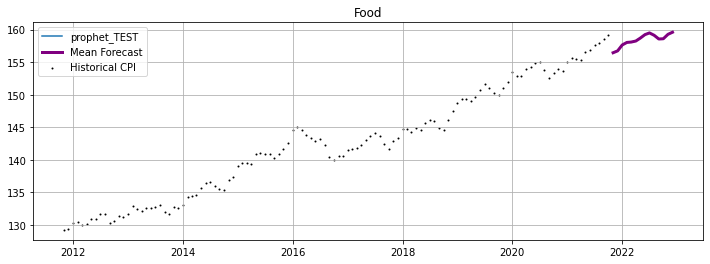

nbeats_TEST
prophet_TEST


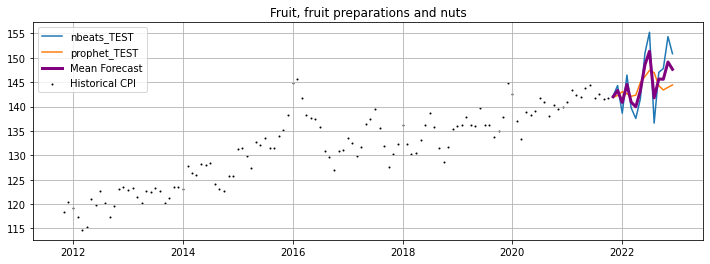

nbeats_TEST
prophet_TEST


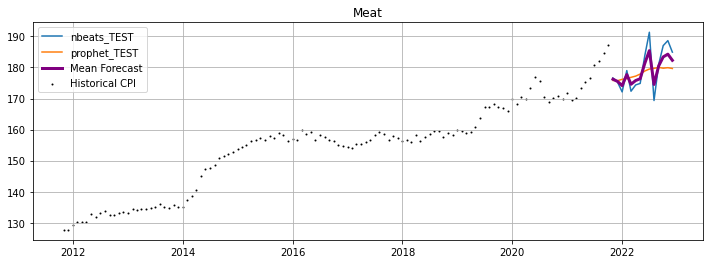

prophet_TEST


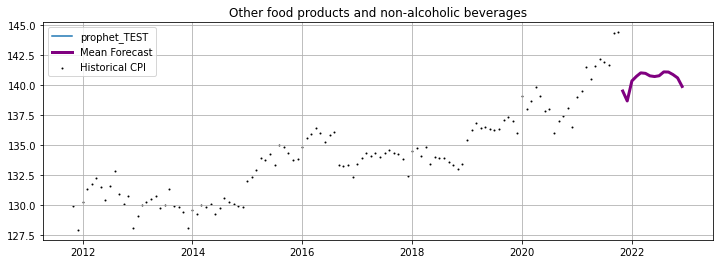

prophet_TEST


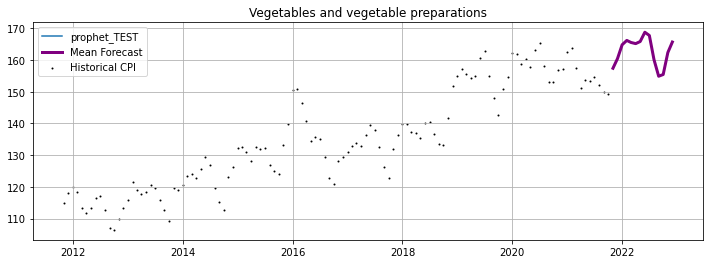

In [35]:
for category in food_categories:

    fig, ax = plt.subplots(figsize=(12,4))
    final_forecasts_df = get_final_forecast_ensemble(category, results)
    final_forecasts_df = final_forecasts_df.loc[final_forecasts_df.index < "2023-01-01"]

    for index, col in enumerate(final_forecasts_df):
        ax.plot(final_forecasts_df[col], color=f"C{index}", label=col)

    ax.plot(final_forecasts_df.mean(axis=1), color="purple", label="Mean Forecast", lw=3)
    ax.scatter(foodprice_df[category].index[-120:], foodprice_df[category].iloc[-120:], color='black', s=1, label='Historical CPI')

    plt.title(category)
    plt.legend()
    plt.grid()
#     plt.savefig(f"./report_output/ensemble_forecast_raw_{category}.svg", bbox_inches='tight')
    plt.show()
    


prophet_TEST


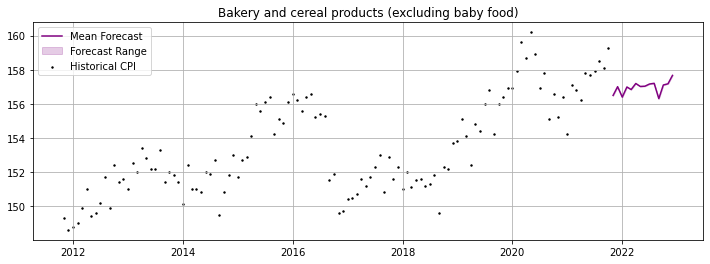

prophet_TEST


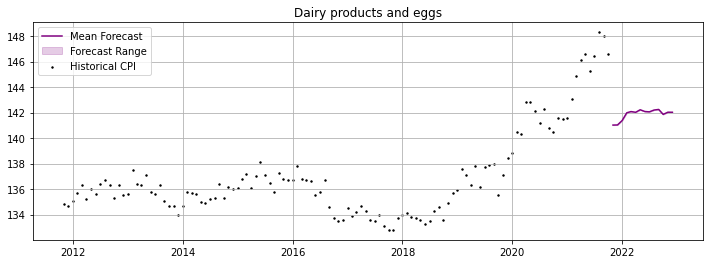

nbeats_TEST
prophet_TEST


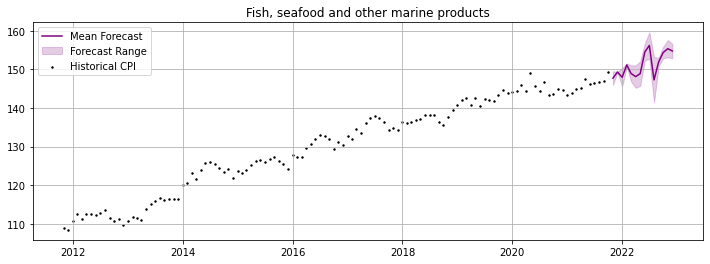

prophet_TEST


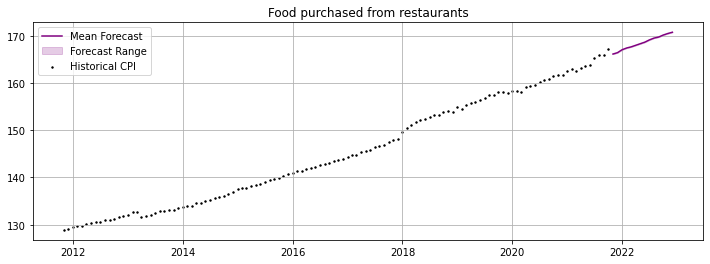

prophet_TEST


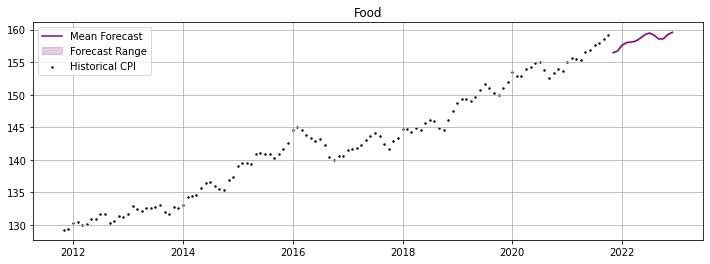

nbeats_TEST
prophet_TEST


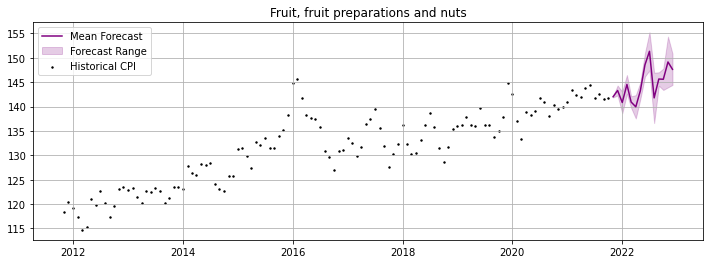

nbeats_TEST
prophet_TEST


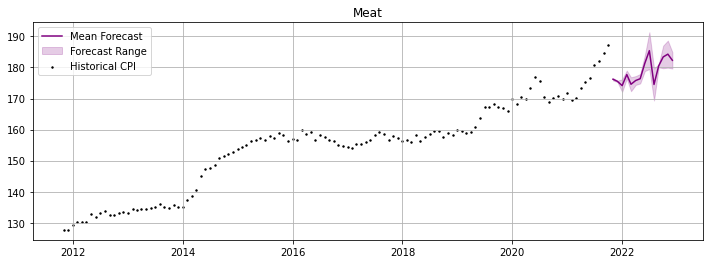

prophet_TEST


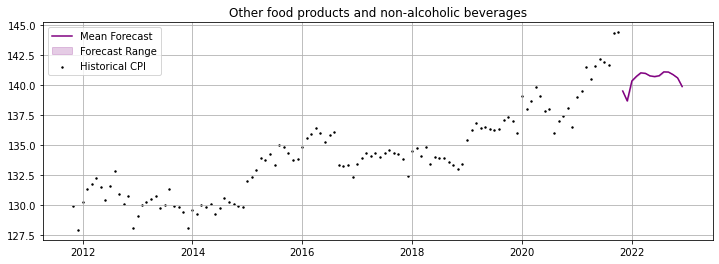

prophet_TEST


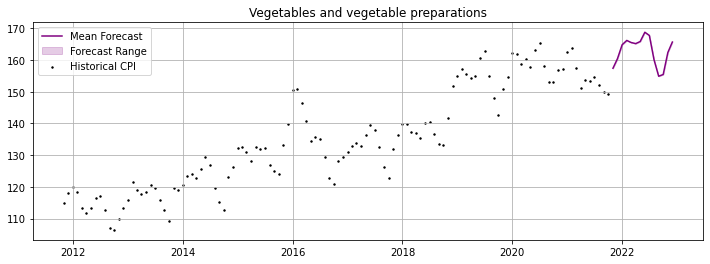

In [36]:
for category in food_categories:

    fig, ax = plt.subplots(figsize=(12,4))
    final_forecasts_df = get_final_forecast_ensemble(category, results)
    final_forecasts_df = final_forecasts_df.loc[final_forecasts_df.index < "2023-01-01"]

    ax.plot(final_forecasts_df.mean(axis=1), color="purple", label="Mean Forecast")
    ax.fill_between(final_forecasts_df.mean(axis=1).index, final_forecasts_df.min(axis=1), final_forecasts_df.max(axis=1), color="purple", alpha=0.2, label='Forecast Range')
    ax.scatter(foodprice_df[category].index[-120:], foodprice_df[category].iloc[-120:], color='black', s=2, label='Historical CPI')

    plt.title(category)
    plt.legend(loc='upper left')
    plt.grid()
    # plt.savefig(f"./report_output/ensemble_forecast_{category}.svg", bbox_inches='tight')
    plt.show()


## Forecast as Predicted Percent Change

Below we compute the expected change in CPI for 2022, relative to mean CPIs in 2021 so far. 

In [37]:
food_forecast_stats = {}
food_forecast_change_stats = {}

for category in food_categories:

    forecast_stats = {}
    forecast_change_stats = {}

    final_forecasts_df = get_final_forecast_ensemble(category, results)
    final_forecasts_df = final_forecasts_df.loc[final_forecasts_df.index < "2023-01-01"]
    historical_cpi = foodprice_df[category]
    
    fc_min = final_forecasts_df.min(axis=1)
    fc_mean = final_forecasts_df.mean(axis=1)
    fc_max = final_forecasts_df.max(axis=1)

    forecast_stats['min'] = historical_cpi.append(fc_min)
    forecast_stats['mean'] = historical_cpi.append(fc_mean)
    forecast_stats['max'] = historical_cpi.append(fc_max)

    food_forecast_stats[category] = pd.DataFrame(forecast_stats)
    food_forecast_stats[category] = food_forecast_stats[category].loc[food_forecast_stats[category].index < "2023-01-01"]

    fc_stats = food_forecast_stats[category].iloc[-12:]
    historical_data = foodprice_df[category].iloc[-9:]

    print(fc_stats)

    forecast_change_stats['2021_mean'] = historical_data.mean()
    forecast_change_stats['2021_max'] = historical_data.max()
    forecast_change_stats['2022_fc_min'] = fc_stats.min().min() 
    forecast_change_stats['2022_fc_mean'] = fc_stats.mean().mean()
    forecast_change_stats['2022_fc_max'] = fc_stats.max().max()

    food_forecast_change_stats[category] = pd.Series(forecast_change_stats)


prophet_TEST
               min    mean     max
2022-01-01 156.393 156.393 156.393
2022-02-01 156.988 156.988 156.988
2022-03-01 156.837 156.837 156.837
2022-04-01 157.193 157.193 157.193
2022-05-01 157.019 157.019 157.019
2022-06-01 157.035 157.035 157.035
2022-07-01 157.161 157.161 157.161
2022-08-01 157.203 157.203 157.203
2022-09-01 156.304 156.304 156.304
2022-10-01 157.105 157.105 157.105
2022-11-01 157.175 157.175 157.175
2022-12-01 157.668 157.668 157.668
prophet_TEST
               min    mean     max
2022-01-01 141.375 141.375 141.375
2022-02-01 141.986 141.986 141.986
2022-03-01 142.080 142.080 142.080
2022-04-01 142.024 142.024 142.024
2022-05-01 142.221 142.221 142.221
2022-06-01 142.085 142.085 142.085
2022-07-01 142.058 142.058 142.058
2022-08-01 142.200 142.200 142.200
2022-09-01 142.247 142.247 142.247
2022-10-01 141.858 141.858 141.858
2022-11-01 142.030 142.030 142.030
2022-12-01 142.027 142.027 142.027
nbeats_TEST
prophet_TEST
               min    mean     max
2022

In [46]:
pd.set_option('display.float_format', lambda x: '%.1f' % x)

results_df = pd.DataFrame(food_forecast_change_stats).T
results_df

,2021_mean,2021_max,2022_fc_min,2022_fc_mean,2022_fc_max
Bakery and cereal products (excluding baby food),157.7,159.3,156.3,157.0,157.7
Dairy products and eggs,146.1,148.3,141.4,142.0,142.2
"Fish, seafood and other marine products",146.4,149.3,141.4,151.6,159.6
Food purchased from restaurants,164.5,167.1,167.0,168.9,170.7
Food,157.0,159.2,157.7,158.7,159.6
"Fruit, fruit preparations and nuts",142.6,144.5,136.6,144.9,155.2
Meat,177.8,187.1,169.4,179.2,191.3
Other food products and non-alcoholic beverages,142.0,144.4,139.9,140.7,141.1
Vegetables and vegetable preparations,154.0,163.8,154.9,163.6,168.8


In [47]:
results_df[['2021_mean', '2022_fc_mean']]

,2021_mean,2022_fc_mean
Bakery and cereal products (excluding baby food),157.7,157.0
Dairy products and eggs,146.1,142.0
"Fish, seafood and other marine products",146.4,151.6
Food purchased from restaurants,164.5,168.9
Food,157.0,158.7
"Fruit, fruit preparations and nuts",142.6,144.9
Meat,177.8,179.2
Other food products and non-alcoholic beverages,142.0,140.7
Vegetables and vegetable preparations,154.0,163.6


In [48]:
## percent change formula from Jim
# P1 = P_0*CPI_1/100 and P2 = P_0*CPI_2/100

p1 = results_df['2021_mean']
p2 = results_df['2022_fc_mean']

(((p2-p1) / p1) * 100).to_frame()


,0
Bakery and cereal products (excluding baby food),-0.4
Dairy products and eggs,-2.8
"Fish, seafood and other marine products",3.6
Food purchased from restaurants,2.7
Food,1.1
"Fruit, fruit preparations and nuts",1.6
Meat,0.8
Other food products and non-alcoholic beverages,-0.9
Vegetables and vegetable preparations,6.2


In [49]:
## percent change formula from Jim
# P1 = P_0*CPI_1/100 and P2 = P_0*CPI_2/100

p1 = results_df['2021_max']
p2 = results_df['2022_fc_max']

(((p2-p1) / p1) * 100).to_frame()


,0
Bakery and cereal products (excluding baby food),-1.0
Dairy products and eggs,-4.1
"Fish, seafood and other marine products",6.9
Food purchased from restaurants,2.2
Food,0.3
"Fruit, fruit preparations and nuts",7.4
Meat,2.3
Other food products and non-alcoholic beverages,-2.3
Vegetables and vegetable preparations,3.1


In [56]:
## Actual percent change from 2020 to 2021 (Up to September, 2021)

p1 = foodprice_df.loc[foodprice_df.index < "2021-01-01"]
p1 = p1.loc[p1.index >= "2020-01-01"]
p1 = p1.mean(axis=0).rename("2020 Mean CPI")

p2 = foodprice_df.loc[foodprice_df.index < "2022-01-01"]
p2 = p2.loc[p2.index >= "2021-01-01"]
p2 = p2.mean(axis=0).rename("2021 Mean CPI")

result = (((p2-p1) / p1) * 100).rename("Percent Change")
pd.concat((p1, p2, result), axis=1)

,2020 Mean CPI,2021 Mean CPI,Percent Change
Bakery and cereal products (excluding baby food),157.5,157.4,-0.1
Dairy products and eggs,141.3,145.7,3.1
"Fish, seafood and other marine products",145.1,146.1,0.7
Food purchased from restaurants,159.9,164.3,2.7
Food,153.7,156.8,2.0
"Fruit, fruit preparations and nuts",139.1,142.4,2.4
Meat,171.2,177.2,3.5
Other food products and non-alcoholic beverages,138.0,141.7,2.7
Vegetables and vegetable preparations,159.0,154.8,-2.6


In [57]:
pct_change_from_mean_results = {}
pct_change_from_max_results = {}

for col in ['2022_fc_min', '2022_fc_mean', '2022_fc_max']:
    change = results_df[["2021_mean", col]].T.pct_change(1)
    pct_change_from_mean_results[col] = change.T[col]
    change = results_df[["2021_max", col]].T.pct_change(1)
    pct_change_from_max_results[col] = change.T[col]

In [58]:
pd.DataFrame(pct_change_from_mean_results)* 100

,2022_fc_min,2022_fc_mean,2022_fc_max
Bakery and cereal products (excluding baby food),-0.9,-0.4,-0.0
Dairy products and eggs,-3.3,-2.8,-2.7
"Fish, seafood and other marine products",-3.4,3.6,9.1
Food purchased from restaurants,1.6,2.7,3.8
Food,0.4,1.1,1.6
"Fruit, fruit preparations and nuts",-4.2,1.6,8.9
Meat,-4.7,0.8,7.6
Other food products and non-alcoholic beverages,-1.5,-0.9,-0.6
Vegetables and vegetable preparations,0.6,6.2,9.6


In [59]:
pd.DataFrame(pct_change_from_max_results)

,2022_fc_min,2022_fc_mean,2022_fc_max
Bakery and cereal products (excluding baby food),-0.0,-0.0,-0.0
Dairy products and eggs,-0.0,-0.0,-0.0
"Fish, seafood and other marine products",-0.1,0.0,0.1
Food purchased from restaurants,-0.0,0.0,0.0
Food,-0.0,-0.0,0.0
"Fruit, fruit preparations and nuts",-0.1,0.0,0.1
Meat,-0.1,-0.0,0.0
Other food products and non-alcoholic beverages,-0.0,-0.0,-0.0
Vegetables and vegetable preparations,-0.1,-0.0,0.0
